In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader 

In [2]:
# Setting hyperparameters
batch_size = 32
epochs = 15
learning_rate = 0.0001
input_shape = 6
hidden_shape = 256
l1 = False
l2 = False
lr_decay = False

In [3]:
df1 = pd.read_csv("bitcoin_data/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv")

print(df1.shape)

(4857377, 8)


In [4]:
df1.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df1.isnull().sum()

Timestamp                  0
Open                 1243608
High                 1243608
Low                  1243608
Close                1243608
Volume_(BTC)         1243608
Volume_(Currency)    1243608
Weighted_Price       1243608
dtype: int64

In [6]:
df1['Volume_(BTC)'].fillna(value=0, inplace=True)
df1['Volume_(Currency)'].fillna(value=0, inplace=True)
df1['Weighted_Price'].fillna(value=0, inplace=True)

# next we need to fix the OHLC (open high low close) data which is a continuous timeseries so
# lets fill forwards those values...
df1['Open'].fillna(method='ffill', inplace=True)
df1['High'].fillna(method='ffill', inplace=True)
df1['Low'].fillna(method='ffill', inplace=True)
df1['Close'].fillna(method='ffill', inplace=True)

print(df1.shape)
df1.isnull().sum()

(4857377, 8)


Timestamp            0
Open                 0
High                 0
Low                  0
Close                0
Volume_(BTC)         0
Volume_(Currency)    0
Weighted_Price       0
dtype: int64

In [7]:
# No EDA and data leakage consideration - just model building.

In [8]:
feature_list = ['Open', 'High', 'Low', 'Close', 'Volume_(BTC)', 'Volume_(Currency)']

target = 'Weighted_Price'

X = df1[feature_list]
y = df1[target]

In [9]:
# Generating dataset

class bitcoin(Dataset):
    def __init__(self, X, y, bias):
        self.X = X.to_numpy()
        self.y = y.to_numpy()
        self.bias = bias
        self.meta= self.preprocess(self.X, self.y)

    def preprocess(self, X, y):
        X_min, y_min = X.min(axis=0), y.min(axis=0)  
        X_max, y_max = X.max(axis=0), y.max(axis=0)  

        meta_data = [X_max, y_max, X_min, y_min]
        return meta_data

        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, index):
        p = (self.X[index, :] - self.meta[2])/(self.meta[0] - self.meta[2] + self.bias)
        q = (self.y[index] - self.meta[3])/(self.meta[1] - self.meta[3] + self.bias)
        return p,q

In [10]:
train = bitcoin(X.iloc[2400000:4500000], y.iloc[2400000:4500000], 1e-4)
train.meta[0][2]

19649.96

In [11]:
val = bitcoin(X.iloc[4500000:4750000], y.iloc[4500000:4750000], 1e-4)
val.meta[0][2]

41905.03

In [12]:
test = bitcoin(X.iloc[4750000:4800000], y.iloc[4750000:4800000], 1e-4)
test.meta[0][2]

52546.26

In [13]:
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test, batch_size=1, shuffle=False)

In [14]:
dataset_iter = iter(train_loader)
temp = next(dataset_iter)
features, labels = temp
print(features.shape, labels.shape)

torch.Size([32, 6]) torch.Size([32])


In [15]:
class LSTMForecasting(nn.Module):
    def __init__(self, input_shape, hidden_shape, output_shape, num_layers):
        super(LSTMForecasting, self).__init__()
        self.hidden = hidden_shape
        self.num_layers = num_layers
        self.rnn = nn.LSTM(input_shape, hidden_shape, num_layers=num_layers)
        self.linear = nn.Linear(hidden_shape, output_shape)

    def forward(self, x):
        h = torch.zeros([self.num_layers, self.hidden], dtype=torch.double).cuda()
        c = torch.zeros([self.num_layers, self.hidden], dtype=torch.double).cuda()
        # print(f"ff {h.dtype}")
        out, (h,c) = self.rnn(x, (h, c))
        out = self.linear(out)
            
        return out  

    def compute_l1(self, w):
        return torch.abs(w).sum()
    
    def compute_l2(self, w):
      return torch.square(w).sum() 

In [16]:
input_shape = 6
model = LSTMForecasting(input_shape, hidden_shape, 1, num_layers=3).double().cuda()

In [17]:
criterions = nn.MSELoss()
optimizers = torch.optim.Adam(model.parameters(), lr=learning_rate)

epoch_schedulers = torch.optim.lr_scheduler.StepLR(optimizers, 5, gamma=0.9)

In [18]:
# Training
l1_weight = 0.01
l2_weight = 0.01
for i in range(epochs):
    mse_train = 0
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        # print(batch_x.dtype)
        optimizers.zero_grad()
        y_pred = model(batch_x)
        y_pred = y_pred.squeeze(1)
        l = criterions(y_pred, batch_y)

        # Using l1 regularization
        if l1:
            l1_parameters = []
            for parameter in model.parameters():
                l1_parameters.append(parameter.view(-1))
            L1 = l1_weight * model.compute_l1(torch.cat(l1_parameters))
            l += L1

        # Using l2 regularization
        if l2:
            l2_parameters = []
            for parameter in model.parameters():
                l2_parameters.append(parameter.view(-1))
            L1 = l2_weight * model.compute_l2(torch.cat(l2_parameters))
            l += L1      

        l.backward()
        mse_train += l.item()*batch_x.shape[0]
        optimizers.step()
    if lr_decay:    
        epoch_schedulers.step()
    with torch.no_grad():
        mse_val = 0
        preds = []
        true = []
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            output = model(batch_x)
            output = output.squeeze(1)
            preds.append(output.detach().cpu().numpy())
            true.append(batch_y.detach().cpu().numpy())
            mse_val += criterions(output, batch_y).item()*batch_x.shape[0]
    preds = np.concatenate(preds)
    true = np.concatenate(true)
        
    print("Iter: ", i, "train: ", (mse_train/train.__len__())**0.5, "val: ", (mse_val/val.__len__())**0.5)


Iter:  0 train:  0.05115115210841248 val:  0.1821386055499659
Iter:  1 train:  0.048441170053048176 val:  0.1803074304493892
Iter:  2 train:  0.048275481773985655 val:  0.1764902735095318
Iter:  3 train:  0.047497790559224394 val:  0.1756855497291829
Iter:  4 train:  0.04675953555589894 val:  0.17484239358423856
Iter:  5 train:  0.04625237073922252 val:  0.17619954570685584
Iter:  6 train:  0.04580052397266769 val:  0.1704886632624085
Iter:  7 train:  0.045340418010258114 val:  0.173071464695473
Iter:  8 train:  0.04477322111797714 val:  0.17700077682157986
Iter:  9 train:  0.04415441610293423 val:  0.17176414550016786
Iter:  10 train:  0.04366811887118311 val:  0.17547296227595138
Iter:  11 train:  0.04322688041858176 val:  0.1794720218463335
Iter:  12 train:  0.04281247302023639 val:  0.17399056462711038
Iter:  13 train:  0.04251669605449638 val:  0.17270583559100275
Iter:  14 train:  0.042179251115772386 val:  0.16964347071078847


313028041.4288961 16071.463540853421


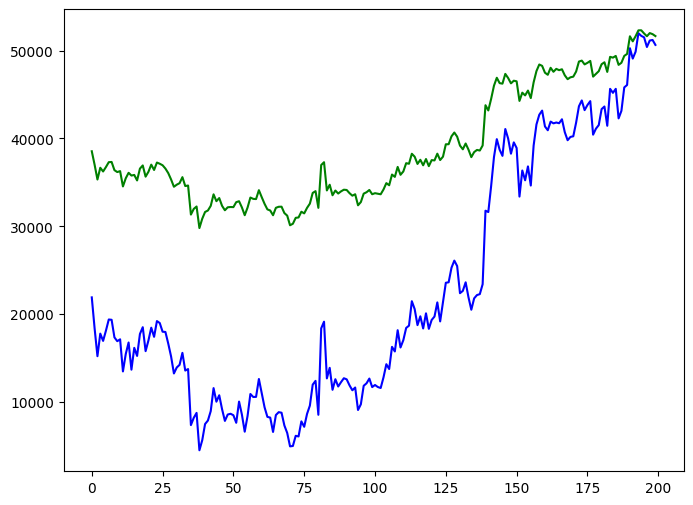

In [21]:
# Testing the model

with torch.no_grad():
    mse_val = 0
    preds = []
    true = []
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        output = model(batch_x)
        output = output.squeeze(1)
        preds.append(output.detach().cpu().numpy())
        true.append(batch_y.detach().cpu().numpy())
        mse_val += criterions(output, batch_y).item()*batch_x.shape[0]
    preds = np.concatenate(preds)
    true = np.concatenate(true)

    # resizing to true value scales
    preds = preds*(test.meta[1] - test.meta[3]) + test.meta[3]
    true = true*(test.meta[1] - test.meta[3]) + test.meta[3]

    mse = mean_squared_error(true, preds)
    mae = mean_absolute_error(true, preds)

    print(mse, mae)
    n = 250
    plt.figure(figsize=(8, 6))
    plt.plot(preds[::n], 'b', label='line 1')
    plt.plot(true[::n], 'g',  label='line 2')
    plt.show()

In [20]:
# https://www.kaggle.com/code/myonin/bitcoin-price-prediction-by-arima/notebook
# https://www.kaggle.com/code/zikazika/using-rnn-and-arima-to-predict-bitcoin-price/notebook